In [1]:
import pandas as pd
import pandas_datareader.data as pdreader
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

## Download S&P500 companies and clear data

In [2]:
# download list of s&p500 companies
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')

In [3]:
symbols_list = sp500['Symbol'].unique().tolist()

In [4]:
end_date = '2025-08-01'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8) # go back to 8 year

In [5]:
df = yf.download(
    tickers=symbols_list,
    start=start_date,
    end=end_date
)

/var/folders/7w/ql6tsk650l71gclng0jwl69c0000gn/T/ipykernel_37514/887579547.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  503 of 503 completed


In [6]:
df = df.stack()

/var/folders/7w/ql6tsk650l71gclng0jwl69c0000gn/T/ipykernel_37514/3911042461.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


In [7]:
df.index.names = ['date', 'ticker']

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df

Price                   close        high         low        open       volume
date       ticker                                                             
2017-08-03 A        56.831112   56.897008   56.454562   56.624011     982900.0
           AAPL     36.236858   36.618863   36.108746   36.581593  108389200.0
           ABBV     50.436569   50.450782   49.988972   50.166591    4400400.0
           ABT      42.694340   42.807243   42.494590   42.781186    4365700.0
           ACGL     30.967594   31.195811   30.856658   31.081705    1155000.0
...                       ...         ...         ...         ...          ...
2025-07-31 XYZ      77.260002   78.080002   76.000000   76.779999    6769800.0
           YUM     144.149994  147.369995  144.110001  145.979996    2653500.0
           ZBH      91.650002   93.199997   91.559998   92.059998    1801600.0
           ZBRA    339.019989  352.660004  329.209991  334.440002    1351200.0
           ZTS     145.789993  148.779999  145.309998  148.000000    4855300.0

[992353 rows x 5 columns]

## Calculate features and technical indicators

In [10]:
def calculate_garman_klass_volatility(high, low, close, open):
    """
    Garman-Klass Volatility is an estimator of price volatility that uses the opening, closing, high, and low prices to 
    provide a more accurate measure of volatility. It aims to improve upon the basic range-based volatility estimators by 
    incorporating more price points within each trading period
    """
    return ((np.log(high)-np.log(low))**2) / 2 - (2 * np.log(2)-1)*((np.log(close)-np.log(open))**2)

def rsi(close, window=20):
    """
    relative strength index: a momentum indicator used in technical analysis, 
    measures the speed and magnitude of a security's recent price changes to detect overbought or oversold conditions in the price of that security
    """
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - 100 / (1 + rs)

def bollinger_bands(close, window=20, std_dev=2):
    """
    helps gauge the volatility of stocks and other securities to determine if they are over- or undervalued
    """
    moving_avg = close.rolling(window=window).mean()
    std_dev = close.rolling(window=window).std()
    upper_band = moving_avg + (std_dev * std_dev)
    middle_band = moving_avg
    lower_band = moving_avg - (std_dev * std_dev)
    return lower_band, middle_band, upper_band

def atr(high, low, close, window=14):
    """
    average true range: a technical indicator used primarily by traders to measure market volatility
    """
    tr = np.maximum(high - low, np.abs(high - close.shift()), np.abs(low - close.shift()))
    return tr.rolling(window=window).mean()

def macd(close, window_fast=12, window_slow=26, window_signal=9):
    """
    moving average convergence divergence: a trend-following momentum indicator that shows the relationship between two moving averages of a security's price
    """
    exp1 = close.ewm(span=window_fast, adjust=False).mean()
    exp2 = close.ewm(span=window_slow, adjust=False).mean()
    return exp1 - exp2, exp1, exp2

def dollar_volume(close, volume, div=1e6):
    """
    dollar volume: a measure of the total value of a security traded over a given period
    """
    return close * volume / div

In [11]:
# garman_klass_vol
df['garman_klass_vol'] = calculate_garman_klass_volatility(
    df['high'], 
    df['low'], 
    df['close'], 
    df['open']
)

# rsi
df['rsi'] = df.groupby(level=1)['close'].transform(rsi)

# bollinger_bands
df['bb_low'] = df.groupby(level=1)['close'].transform(lambda x: bollinger_bands(np.log1p(x), window=20)[0])
df['bb_mid'] = df.groupby(level=1)['close'].transform(lambda x: bollinger_bands(np.log1p(x), window=20)[1])
df['bb_high'] = df.groupby(level=1)['close'].transform(lambda x: bollinger_bands(np.log1p(x), window=20)[2])

# atr
df['atr'] = df.groupby(level=1, group_keys=False).apply(lambda x: atr(x['high'], x['low'], x['close']))

# macd
df['macd'] = df.groupby(level=1, group_keys=False).apply(lambda x: macd(x['close'])[0])

# dollar_volume
df['dollar_volume'] = dollar_volume(df['close'], df['volume'])

In [12]:
df

Price                   close        high         low        open  \
date       ticker                                                   
2017-08-03 A        56.831112   56.897008   56.454562   56.624011   
           AAPL     36.236858   36.618863   36.108746   36.581593   
           ABBV     50.436569   50.450782   49.988972   50.166591   
           ABT      42.694340   42.807243   42.494590   42.781186   
           ACGL     30.967594   31.195811   30.856658   31.081705   
...                       ...         ...         ...         ...   
2025-07-31 XYZ      77.260002   78.080002   76.000000   76.779999   
           YUM     144.149994  147.369995  144.110001  145.979996   
           ZBH      91.650002   93.199997   91.559998   92.059998   
           ZBRA    339.019989  352.660004  329.209991  334.440002   
           ZTS     145.789993  148.779999  145.309998  148.000000   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-08-03 A          982900.0          0.000025        NaN       NaN   
           AAPL    108389200.0          0.000064        NaN       NaN   
           ABBV      4400400.0          0.000031        NaN       NaN   
           ABT       4365700.0          0.000025        NaN       NaN   
           ACGL      1155000.0          0.000055        NaN       NaN   
...                        ...               ...        ...       ...   
2025-07-31 XYZ       6769800.0          0.000350  62.876359  4.301274   
           YUM       2653500.0          0.000189  40.527820  5.001616   
           ZBH       1801600.0          0.000150  45.490009  4.559110   
           ZBRA      1351200.0          0.002296  61.888943  5.796529   
           ZTS       4855300.0          0.000191  29.084162  5.033755   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-08-03 A            NaN       NaN       NaN  0.000000      55.859300  
           AAPL         NaN       NaN       NaN  0.000000    3927.684089  
           ABBV         NaN       NaN       NaN  0.000000     221.941079  
           ABT          NaN       NaN       NaN  0.000000     186.390679  
           ACGL         NaN       NaN       NaN  0.000000      35.767571  
...                     ...       ...       ...       ...            ...  
2025-07-31 XYZ     4.306740  4.312205  2.720071  3.672373     523.034762  
           YUM     5.001875  5.002134  2.602859 -0.302915     382.502009  
           ZBH     4.559408  4.559707  1.998572  0.260131     165.116643  
           ZBRA    5.796898  5.797266  8.253571  8.081636     458.083809  
           ZTS     5.034350  5.034945  2.890717 -2.573019     707.854154  

[992353 rows x 13 columns]

## Filter top 150 most liquid stocks for each month

In [13]:
last_cols = [c for c in df.columns.unique(0) if c not in ['adj close','dollar_volume', 'volume', 'open', 'high', 'low']]

data = (pd.concat(
  [
    df.unstack()[last_cols].resample('ME').last().stack('ticker'), # get the last day of each month for indicators
    df.unstack('ticker')['dollar_volume'].resample('ME').mean().stack('ticker').to_frame('dollar_volume') # get the mean dollar volume for each month
  ], axis=1
)).dropna()

/var/folders/7w/ql6tsk650l71gclng0jwl69c0000gn/T/ipykernel_37514/3917006892.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df.unstack()[last_cols].resample('ME').last().stack('ticker'), # get the last day of each month for indicators


In [14]:
# 5 year rolling mean
data['dollar_volume'] = data.loc[:, 'dollar_volume'].unstack('ticker').rolling(window=5*12, min_periods=12).mean().stack()
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data = data[data['dollar_vol_rank']<150].drop(columns=['dollar_volume','dollar_vol_rank'])

In [15]:
data

close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-07-31 AAPL     45.013176          0.000108  55.423735  3.829578   
           ABBV     67.831650          0.000085  50.102410  4.243733   
           ABT      58.008183          0.000028  69.550388  4.043535   
           ACN     142.835815          0.000099  40.346351  5.005244   
           ADBE    244.679993          0.000267  51.089289  5.537517   
...                       ...               ...        ...       ...   
2025-07-31 WDAY    229.380005          0.000242  43.466711  5.461494   
           WFC      80.629997          0.000164  45.659804  4.418004   
           WMT      97.980003          0.000079  51.365324  4.579604   
           XOM     111.639999          0.000133  51.333024  4.724953   
           XYZ      77.260002          0.000350  62.876359  4.301274   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-07-31 AAPL    3.829757  3.829937  0.618410  0.267312  
           ABBV    4.244484  4.245236  1.652686 -0.803119  
           ABT     4.044114  4.044692  0.962842  0.873384  
           ACN     5.005487  5.005731  1.881961 -0.013293  
           ADBE    5.538224  5.538930  6.321432  1.168924  
...                     ...       ...       ...       ...  
2025-07-31 WDAY    5.462241  5.462987  4.956426 -1.119639  
           WFC     4.418351  4.418698  1.773571  1.080116  
           WMT     4.579811  4.580017  1.212142  0.290798  
           XOM     4.725319  4.725685  1.779287  0.412237  
           XYZ     4.306740  4.312205  2.720071  3.672373  

[12665 rows x 8 columns]

## Monthly returns for different time horizons as features

In [16]:
def calculate_returns(df):
  outlier_cutoff = 0.005 # 5% outlier cutoff
  horizons = [1,2,3,6,9,12]
  for h in horizons:
    df[f'ret_{h}m'] = df[f'close'].pct_change(h).pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff))).add(1).pow(1/h).sub(1)
  return df

In [17]:
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

In [18]:
data

close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-07-31 AAPL     51.161804          0.000988  63.801844  3.918773   
           ABBV     51.567150          0.000339  22.432275  3.995645   
           ABT      78.377129          0.000211  59.094649  4.365409   
           ACN     175.664734          0.000338  58.939850  5.181229   
           ADBE    298.859985          0.000442  47.257711  5.729635   
...                       ...               ...        ...       ...   
2025-07-31 WDAY    229.380005          0.000242  43.466711  5.461494   
           WFC      80.629997          0.000164  45.659804  4.418004   
           WMT      97.980003          0.000079  51.365324  4.579604   
           XOM     111.639999          0.000133  51.333024  4.724953   
           XYZ      77.260002          0.000350  62.876359  4.301274   

                     bb_mid   bb_high       atr      macd    ret_1m    ret_2m  \
date       ticker                                                               
2019-07-31 AAPL    3.919018  3.919263  0.819773  0.825820  0.076395  0.103125   
           ABBV    3.996345  3.997046  1.036674 -1.339401 -0.069913 -0.061006   
           ABT     4.365846  4.366283  1.382559  1.334672  0.039551  0.071625   
           ACN     5.181336  5.181443  2.023704  2.181188  0.042269  0.039945   
           ADBE    5.729732  5.729830  5.210002  3.373777  0.014288  0.050339   
...                     ...       ...       ...       ...       ...       ...   
2025-07-31 WDAY    5.462241  5.462987  4.956426 -1.119639 -0.044250 -0.037710   
           WFC     4.418351  4.418698  1.773571  1.080116  0.006365  0.038378   
           WMT     4.579811  4.580017  1.212142  0.290798  0.002045 -0.003755   
           XOM     4.725319  4.725685  1.779287  0.412237  0.035621  0.044653   
           XYZ     4.306740  4.312205  2.720071  3.672373  0.137347  0.118559   

                     ret_3m    ret_6m    ret_9m   ret_12m  
date       ticker                                          
2019-07-31 AAPL    0.021447  0.043411 -0.001704  0.010727  
           ABBV   -0.052010 -0.026044 -0.012728 -0.022586  
           ABT     0.031927  0.031261  0.027741  0.025396  
           ACN     0.017766  0.039898  0.023445  0.017390  
           ADBE    0.010954  0.031704  0.021973  0.016808  
...                     ...       ...       ...       ...  
2025-07-31 WDAY   -0.021720 -0.021954 -0.002142  0.000825  
           WFC     0.045164  0.005574  0.026211  0.027911  
           WMT     0.003303  0.000554  0.020884  0.030979  
           XOM     0.021734  0.010406 -0.002082 -0.002174  
           XYZ     0.097338 -0.026591  0.007369  0.018670  

[10460 rows x 14 columns]

## Fama-French Factors and calculate Rolling Factors Betas

In [19]:
factor_data = pdreader.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0]

/var/folders/7w/ql6tsk650l71gclng0jwl69c0000gn/T/ipykernel_37514/2626219523.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = pdreader.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0]
/var/folders/7w/ql6tsk650l71gclng0jwl69c0000gn/T/ipykernel_37514/2626219523.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = pdreader.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0]


In [20]:
factor_data = factor_data.drop('RF', axis=1)
factor_data.index = pd.to_datetime(factor_data.index.to_timestamp())
factor_data = factor_data.resample('ME').last() # resample to monthly and take last day of month
factor_data = factor_data.div(100)
factor_data.index.name = "date"
factor_data = factor_data.join(data['ret_1m']).sort_index() # join with monthly returns

In [21]:
# filter out stocks with less than 10 months of data
window = 10
observations = factor_data.groupby(level=1).size()
valid_stock = observations[observations >= window]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stock.index)]

In [22]:
factor_data

Mkt-RF     SMB    HML     RMW     CMA    ret_1m
date       ticker                                                 
2019-07-31 AAPL    0.0122 -0.0182  0.005 -0.0013  0.0037  0.076395
           ABBV    0.0122 -0.0182  0.005 -0.0013  0.0037 -0.069913
           ABT     0.0122 -0.0182  0.005 -0.0013  0.0037  0.039551
           ACN     0.0122 -0.0182  0.005 -0.0013  0.0037  0.042269
           ADBE    0.0122 -0.0182  0.005 -0.0013  0.0037  0.014288
...                   ...     ...    ...     ...     ...       ...
2025-06-30 WDAY    0.0486 -0.0002 -0.016 -0.0319  0.0145 -0.031125
           WFC     0.0486 -0.0002 -0.016 -0.0319  0.0145  0.071410
           WMT     0.0486 -0.0002 -0.016 -0.0319  0.0145 -0.009522
           XOM     0.0486 -0.0002 -0.016 -0.0319  0.0145  0.053763
           XYZ     0.0486 -0.0002 -0.016 -0.0319  0.0145  0.100081

[10251 rows x 6 columns]

In [23]:
# calculate rolling factor betas
betas = factor_data.groupby(
  level=1, 
  group_keys=False).apply(lambda x: RollingOLS(
    endog = x['ret_1m'], 
    exog=sm.add_constant(x.drop('ret_1m', axis=1)),
    window=min(x.shape[0], 24),
    min_nobs = len(x.columns) + 1
  ).fit().params.drop('const', axis=1)
)

In [24]:
data = data.join(betas.groupby('ticker').shift())

In [25]:
# impute missing values
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [26]:
data = data.dropna()
data = data.drop('close', axis=1)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10252 entries, (Timestamp('2019-07-31 00:00:00'), 'AAPL') to (Timestamp('2025-07-31 00:00:00'), 'XYZ')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10252 non-null  float64
 1   rsi               10252 non-null  float64
 2   bb_low            10252 non-null  float64
 3   bb_mid            10252 non-null  float64
 4   bb_high           10252 non-null  float64
 5   atr               10252 non-null  float64
 6   macd              10252 non-null  float64
 7   ret_1m            10252 non-null  float64
 8   ret_2m            10252 non-null  float64
 9   ret_3m            10252 non-null  float64
 10  ret_6m            10252 non-null  float64
 11  ret_9m            10252 non-null  float64
 12  ret_12m           10252 non-null  float64
 13  Mkt-RF            10252 non-null  float64
 14  SMB               10252 non-null  float64
 15  HML       

## K-Means Clustering Algorithm

In [28]:
from sklearn.cluster import KMeans

In [41]:
data.columns[0]

'garman_klass_vol'

In [44]:
# pre-defined centroids
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), len(data.columns.unique()) - 1)) # 18 features
initial_centroids[:, 1] = target_rsi_values

In [46]:
def get_clusters(df, n_clusters=4):
  df['cluster'] = KMeans(
    n_clusters=n_clusters,
    random_state=42,
    init=initial_centroids
  ).fit(df).labels_
  return df

In [47]:
data = data.dropna().groupby('date', group_keys = False).apply(get_clusters)

In [49]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-07-31 AAPL            0.000988  63.801844  3.918773  3.919018  3.919263   
           ABBV            0.000339  22.432275  3.995645  3.996345  3.997046   
           ABT             0.000211  59.094649  4.365409  4.365846  4.366283   
           ACN             0.000338  58.939850  5.181229  5.181336  5.181443   
           ADBE            0.000442  47.257711  5.729635  5.729732  5.729830   
...                             ...        ...       ...       ...       ...   
2025-07-31 WDAY            0.000242  43.466711  5.461494  5.462241  5.462987   
           WFC             0.000164  45.659804  4.418004  4.418351  4.418698   
           WMT             0.000079  51.365324  4.579604  4.579811  4.580017   
           XOM             0.000133  51.333024  4.724953  4.725319  4.725685   
           XYZ             0.000350  62.876359  4.301274  4.306740  4.312205   

                        atr      macd    ret_1m    ret_2m    ret_3m    ret_6m  \
date       ticker                                                               
2019-07-31 AAPL    0.819773  0.825820  0.076395  0.103125  0.021447  0.043411   
           ABBV    1.036674 -1.339401 -0.069913 -0.061006 -0.052010 -0.026044   
           ABT     1.382559  1.334672  0.039551  0.071625  0.031927  0.031261   
           ACN     2.023704  2.181188  0.042269  0.039945  0.017766  0.039898   
           ADBE    5.210002  3.373777  0.014288  0.050339  0.010954  0.031704   
...                     ...       ...       ...       ...       ...       ...   
2025-07-31 WDAY    4.956426 -1.119639 -0.044250 -0.037710 -0.021720 -0.021954   
           WFC     1.773571  1.080116  0.006365  0.038378  0.045164  0.005574   
           WMT     1.212142  0.290798  0.002045 -0.003755  0.003303  0.000554   
           XOM     1.779287  0.412237  0.035621  0.044653  0.021734  0.010406   
           XYZ     2.720071  3.672373  0.137347  0.118559  0.097338 -0.026591   

                     ret_9m   ret_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                               
2019-07-31 AAPL   -0.001704  0.010727  1.210202 -0.043518 -0.675877  0.425980   
           ABBV   -0.012728 -0.022586  0.538073  0.079471 -0.015121  0.240453   
           ABT     0.027741  0.025396  0.787017 -0.081815 -0.294831  0.027357   
           ACN     0.023445  0.017390  1.140444 -0.168497 -0.235655  0.158164   
           ADBE    0.021973  0.016808  1.414874 -0.653265 -0.189425  0.288873   
...                     ...       ...       ...       ...       ...       ...   
2025-07-31 WDAY   -0.002142  0.000825  1.162609 -0.632776 -0.280169 -0.976395   
           WFC     0.026211  0.027911  1.066705 -0.139100  1.542278 -0.834848   
           WMT     0.020884  0.030979  0.673942 -0.264971 -0.337652  0.252803   
           XOM    -0.002082 -0.002174  0.915303 -0.115327  0.950860 -0.294612   
           XYZ     0.007369  0.018670  2.420125  0.411875 -0.059591 -2.251529   

                        CMA  cluster  
date       ticker                     
2019-07-31 AAPL    0.369715        3  
           ABBV    0.634431        0  
           ABT     0.954821        2  
           ACN    -0.077209        2  
           ADBE   -0.449783        1  
...                     ...      ...  
2025-07-31 WDAY   -0.501425        1  
           WFC    -1.039588        1  
           WMT     0.482585        1  
           XOM     0.342565        1  
           XYZ    -0.241279        3  

[10252 rows x 19 columns]

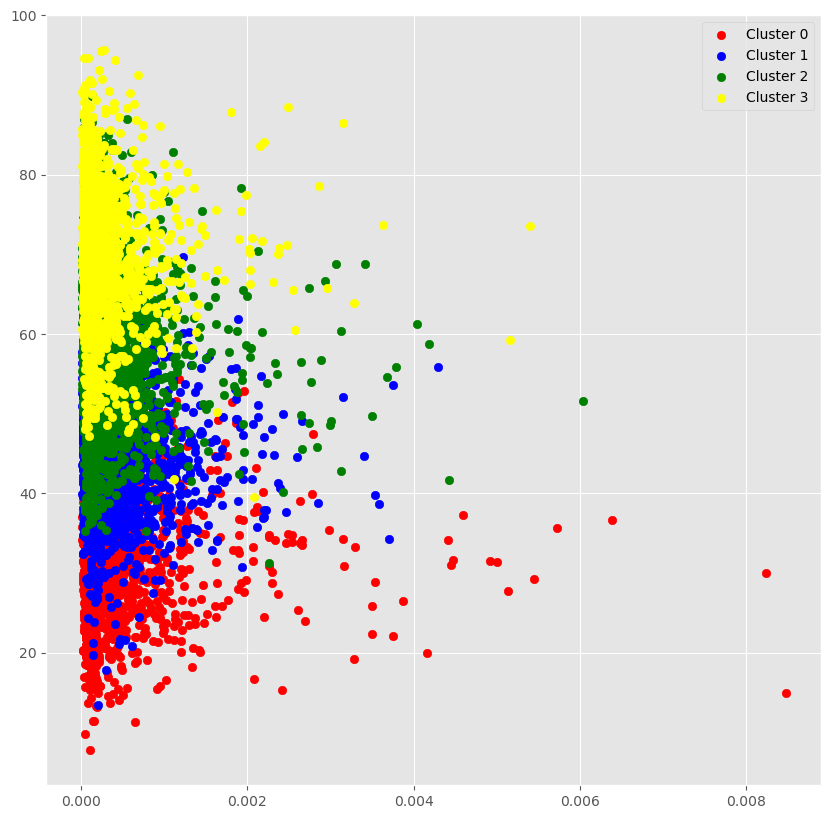

In [50]:
def plot_clusters(df):
  cluster_0 = df[df['cluster'] == 0]
  cluster_1 = df[df['cluster'] == 1]
  cluster_2 = df[df['cluster'] == 2]
  cluster_3 = df[df['cluster'] == 3]

  plt.figure(figsize=(10, 10))
  plt.style.use('ggplot')

  plt.scatter(cluster_0.iloc[:, 0], cluster_0.iloc[:, 1], c='red', label='Cluster 0')
  plt.scatter(cluster_1.iloc[:, 0], cluster_1.iloc[:, 1], c='blue', label='Cluster 1')
  plt.scatter(cluster_2.iloc[:, 0], cluster_2.iloc[:, 1], c='green', label='Cluster 2')
  plt.scatter(cluster_3.iloc[:, 0], cluster_3.iloc[:, 1], c='yellow', label='Cluster 3')
  plt.legend()
  plt.show()
  return

plot_clusters(data)

## Select best stocks to invest in a certain month

In [64]:
filtered_df = data[data['cluster'] == 3].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df.reset_index().set_index(['date', 'ticker'])
filtered_df

,ticker,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,ret_1m,ret_2m,ret_3m,ret_6m,ret_9m,ret_12m,Mkt-RF,SMB,HML,RMW,CMA,cluster
date,,,,,,,,,,,,,,,,,,,,
2019-08-01,AAPL,0.000988,63.801844,3.918773,3.919018,3.919263,0.819773,0.825820,0.076395,0.103125,0.021447,0.043411,-0.001704,0.010727,1.210202,-0.043518,-0.675877,0.425980,0.369715,3
2019-08-01,AMAT,0.000524,66.207834,3.821238,3.824746,3.828254,1.276329,1.846122,0.099310,0.129620,0.040348,0.041494,0.048039,0.002962,1.433746,0.540664,0.179527,0.338601,-0.597121,3
2019-08-01,BAC,0.000107,64.796824,3.281319,3.281788,3.282257,0.423603,0.484042,0.057931,0.076854,0.002889,0.014308,0.014040,0.001199,1.302643,-0.182329,1.465002,-0.634339,-0.707783,3
2019-08-01,CMG,0.000213,69.554648,2.784512,2.785302,2.786092,0.347586,0.363055,0.085485,0.097909,0.049577,0.070163,0.062670,0.051862,1.135776,-0.202275,-0.957786,-0.090900,0.559468,3
2019-08-01,COST,0.000272,66.334602,5.536495,5.536812,5.537129,2.650008,3.838819,0.043026,0.072600,0.040234,0.043510,0.021872,0.020334,0.832018,0.017491,-0.384107,0.347375,0.019662,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01,SPGI,0.000844,65.650363,6.271834,6.271986,6.272138,9.067858,4.917746,0.045155,0.036611,0.033574,0.009889,0.015992,0.011360,1.199174,-0.064675,-0.222655,0.154257,0.038950,3
2025-08-01,TMO,0.000633,60.760107,6.086261,6.089960,6.093659,16.478568,16.767653,0.153455,0.078062,0.029549,-0.039772,-0.016834,-0.022076,0.809267,-0.078766,-0.320117,0.143874,0.401853,3
2025-08-01,TTD,0.000434,73.310084,4.396819,4.400346,4.403874,3.276714,3.796655,0.207946,0.075210,0.174818,-0.050510,-0.035337,-0.002748,0.808264,1.066728,-1.701087,-0.883983,0.923869,3


In [66]:
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}

for d in dates:
  fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df[filtered_df.index == d]['ticker'].tolist()

fixed_dates

{'2019-08-01': ['AAPL',
  'AMAT',
  'BAC',
  'CMG',
  'COST',
  'FDX',
  'GM',
  'GOOG',
  'GOOGL',
  'GS',
  'HUM',
  'IBM',
  'INTU',
  'LRCX',
  'MDT',
  'MU',
  'NOC',
  'PANW',
  'PG',
  'SBUX',
  'SCHW',
  'SHW',
  'TXN',
  'UPS',
  'USB',
  'VLO',
  'XYZ'],
 '2019-09-01': ['AMGN',
  'AMT',
  'BA',
  'BKNG',
  'CHTR',
  'CMG',
  'COST',
  'CRM',
  'CVS',
  'EL',
  'HD',
  'INTU',
  'KO',
  'LMT',
  'LOW',
  'MDT',
  'NEE',
  'NOC',
  'PEP',
  'QCOM',
  'STZ',
  'TGT',
  'VZ'],
 '2019-10-01': ['AAPL',
  'ABBV',
  'BAC',
  'BLK',
  'BMY',
  'C',
  'CSCO',
  'DE',
  'GE',
  'IBM',
  'INTC',
  'JPM',
  'LRCX',
  'MPC',
  'NEE',
  'NKE',
  'PM',
  'RTX',
  'SCHW',
  'T',
  'USB',
  'VLO',
  'VZ',
  'WFC',
  'WMT'],
 '2019-11-01': ['AAPL',
  'ABBV',
  'ALGN',
  'AMD',
  'AMGN',
  'AZO',
  'BAC',
  'BIIB',
  'BKNG',
  'BLK',
  'BMY',
  'CAT',
  'CHTR',
  'CI',
  'ELV',
  'GS',
  'HUM',
  'INTC',
  'JPM',
  'MS',
  'PANW',
  'PFE',
  'REGN',
  'RTX',
  'SCHW',
  'TMUS',
  'TSLA',
  'UAL'

In [67]:
# portfolio optimization function
from pypfopt import risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

In [83]:
def optimize_weights(prices, lower_bound=0):
  returns = expected_returns.mean_historical_return(
    prices=prices,
    frequency=252
  )
  cov_matrix = risk_models.sample_cov(
    prices=prices,
    frequency=252
  )
  ef = EfficientFrontier(
    expected_returns=returns,
    cov_matrix=cov_matrix,
    weight_bounds=(lower_bound, .1), # bounds for the weights
    solver='SCS' # solver for the optimization - SCS: sparse second-order cone solver
  )

  weights = ef.max_sharpe()
  return ef.clean_weights()

In [71]:
# download daily prices
stocks = data.index.get_level_values('ticker').unique().tolist()

In [73]:
new_df = yf.download(
  tickers=stocks,
  start=data.index.get_level_values('date').min()-pd.DateOffset(months=12),
  end=data.index.get_level_values('date').max()
)

/var/folders/7w/ql6tsk650l71gclng0jwl69c0000gn/T/ipykernel_37514/3609063723.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  new_df = yf.download(
[*********************100%***********************]  155 of 155 completed


In [74]:
new_df.head()

Price           Close                                                     \
Ticker           AAPL       ABBV ABNB        ABT         ACN        ADBE   
Date                                                                       
2018-07-31  45.013180  67.831627  NaN  58.008179  142.835846  244.679993   
2018-08-01  47.664906  69.067223  NaN  57.335529  143.176514  248.009995   
2018-08-02  49.058189  69.957115  NaN  57.158512  143.570938  252.220001   
2018-08-03  49.200127  70.994133  NaN  57.733795  143.768158  253.279999   
2018-08-06  49.455597  71.383919  NaN  57.742661  143.956436  254.110001   

Price                                                      ...   Volume  \
Ticker            ADI         ADP        ADSK        ALGN  ...     VRTX   
Date                                                       ...            
2018-07-31  84.351044  116.544380  128.440002  356.649994  ...  1529400   
2018-08-01  84.263306  114.489624  127.180000  353.700012  ...  1384500   
2018-08-02  84.394882  114.955833  131.160004  367.920013  ...  1684300   
2018-08-03  84.719528  115.905510  132.050003  363.510010  ...  1118000   
2018-08-06  85.438965  117.036514  134.350006  369.549988  ...   761500   

Price                                                                         \
Ticker            VZ      WBA     WDAY      WDC       WFC       WMT     WYNN   
Date                                                                           
2018-07-31  16924200  7261900  1335200  6554804  21633800  20124300  1955700   
2018-08-01  12789400  6514800  1446700  6217439  19192700  15150000  4672000   
2018-08-02  12337500  5815900  1200300  6260568  13489100  12918300  7324500   
2018-08-03   7769900  4307300   819600  6208839  13720400  17241600  3543800   
2018-08-06  10768400  5108900   803700  4739515  13360500  13954800  2117900   

Price                           
Ticker           XOM       XYZ  
Date                            
2018-07-31  11716800  10692300  
2018-08-01   8936300  11990400  
2018-08-02   8364300  20831900  
2018-08-03   7811100  14949000  
2018-08-06  10041800  10876000  

[5 rows x 775 columns]

In [ ]:
# calculate daily returns for each stock for our portfolio
returns_df = np.log(new_df['Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  try:
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date] # stocks for the given month
    
    optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d') # get prices from 1 year prior to the start date
    optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(1)).strftime('%Y-%m-%d')

    optimization_df = new_df[optimization_start_date:optimization_end_date]['Close'][cols]

    sharpe_success = False
    try:
      weights = optimize_weights(optimization_df, lower_bound=round(1/len((optimization_df.columns)*2),3))
      weights = pd.DataFrame(weights, index=pd.Series(0))
      sharpe_success = True
    except:
      print(f"Max Sharpe weights not found for {start_date}, continuing with equal weights")

    if not sharpe_success:
      weights = pd.DataFrame([1/len(optimization_df.columns) for _ in range(len(optimization_df.columns))], index=optimization_df.columns, columns=pd.Series(0)).T

    temp_df = returns_df[start_date:end_date]
    temp_df = temp_df.stack().to_frame('return').reset_index(level=0).merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True), left_index=True, right_index=True).reset_index().set_index(['Date', 'Ticker']).unstack().stack()
    temp_df.index_names = ['date', 'ticker']
    temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

    temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
  except Exception as e:
    print(f"Error: {e}")
    continue

In [137]:
portfolio_df = portfolio_df.drop_duplicates()

<Axes: xlabel='Date'>

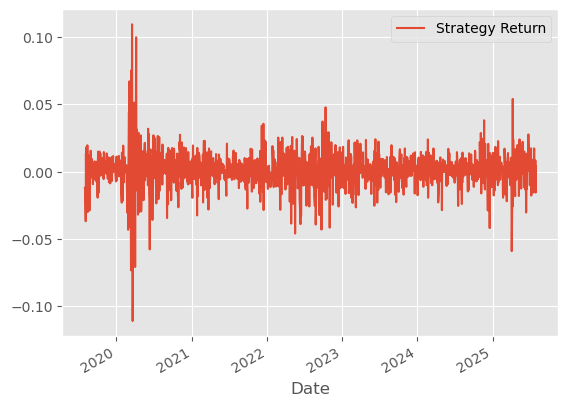

In [138]:
portfolio_df.plot()

## Visualizing portfolio returns

In [139]:
spy = yf.download(tickers='SPY', start=data.index.get_level_values('date').min()-pd.DateOffset(months=12), end=data.index.get_level_values('date').max())

/var/folders/7w/ql6tsk650l71gclng0jwl69c0000gn/T/ipykernel_37514/1150384222.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download(tickers='SPY', start=data.index.get_level_values('date').min()-pd.DateOffset(months=12), end=data.index.get_level_values('date').max())
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

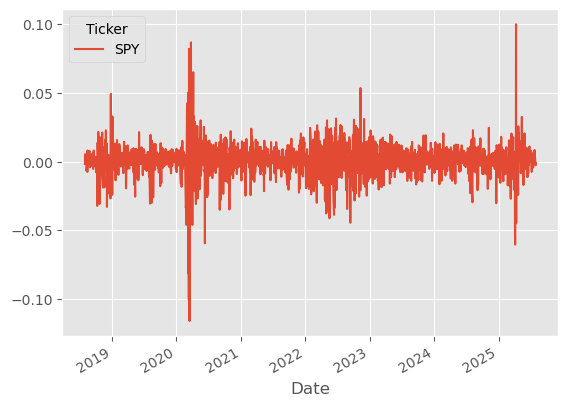

In [144]:
spy_ret = np.log(spy['Close']).diff().dropna().rename({'Close': 'SPY Buy&Hold'}, axis=1)
spy_ret.plot()

In [ ]:
portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

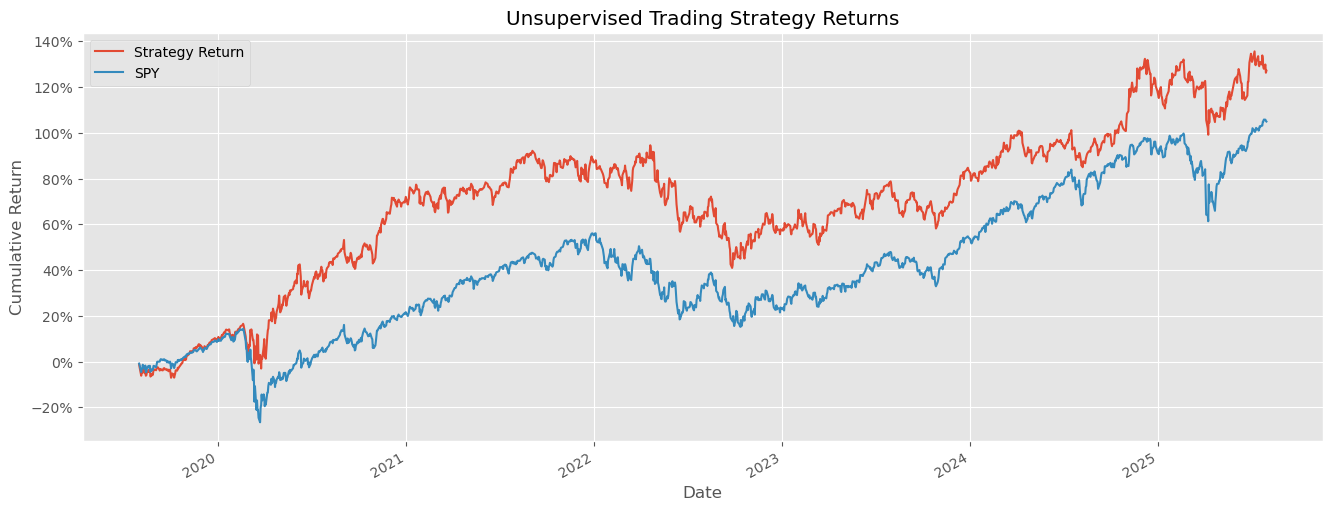

In [160]:
import matplotlib.ticker as mticker

plt.style.use('ggplot')
portfolio_comulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1 # cumulative return
portfolio_comulative_return.plot(figsize=(16, 6))
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1))
plt.title('Unsupervised Trading Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()